# PDG API tutorial, PyHEP 2024

## Introduction

This is a whirlwind tour of the new PDG Python API!

## Installation

(Optional) First, create a virtual environment and activate it:

```bash
python -m venv ~/pdg.venv
source ~/pdg.venv/bin/activate
```

Now install the package:

```bash
pip install pdg
```

## Preamble

Unless otherwise noted, we assume the following preamble has been run:

In [65]:
import pdg
from pdg.particle import PdgParticle
import matplotlib.pyplot as plt
import numpy as np

api = pdg.connect()

plt.style.use('dark_background')

## Concepts 

### Editions

There are multiple editions of the PDG database corresponding to the (bi)annual PDG releases. There is also a pdgall.sqlite containing data from all historical editions.

### PDG IDs and nodes 

Here, *PDG IDs* are used to to identify particles, properties of particles, and other quantities of interest. PDG IDs can have parent PDG IDs; for example, the parent PDG ID for a particle's mass will be the PDG ID of the particle itself. Top-level PDG IDs, such as those of particles, generally take the form of a letter followed by three digits. The PDG ID for a particle property takes the form of the parent PDG ID, a period, then some digits. A specific edition can be appended with a slash.

Unlike Monte Carlo IDs, which always identify specific states, a PDG ID can represent multiple states from a multiplet.

#### The `get` function

### Monte Carlo IDs 

Monte Carlo IDs (oftened called "PDG IDs" in the community) are used in MC generators and identify specific states. They are assigned algorithmically, with some historical special cases.

### Basic particle properties

Basic properties, particularly quantum numbers, are directly associated to particles.

### Summary table values 

Measured quantities, such as particle properties, are summarized by the PDG in *summary tables*, which list the PDG's evaluation (e.g. an average or fit) of the quantity based on measurements in the literature. The individual measurements are listed in *listings*. Currently, the API provides access to summary table values. Support for the listings will be added in the future.

A given PDG ID may have multiple summary table values, corresponding, for example, to different measurement techniques.

#### Parent PDG IDs 

A particle property listed in the summary tables will have the particle itself as its parent PDG ID.

#### Sort order

Quantities may have multiple summary table values, in which case the database specifies their ordering.

#### Flags

Additionally, when there are multiple summary table values for a quantity, they may use flags???? Or is this in pdgid/?????

#### "Best" summaries

When multiple values are available, the API can provide the "best" one, i.e. the first-sorted one with flags that match.

### Items and their mappings

Decays may be expressed in terms of "generic" particles: pions, leptons, etc. More generally, every "thing" in a decay is a *PDG item*. Some items correspond to specific particle states (MC IDs), while others correspond to other (specific) items, either mapping to one particular item (a *shortcut* or *alias*) or mapping to multiple (a *generic* item). The database defines this map between items. 

## Exercises

### Getting a particle

Particles are represented by the `PdgParticle` class. There are multiple ways to get a particle from the API. Depending on the method, the result can be a `PdgParticleList`, a generic `PdgParticle`, or a specific `PdgParticle`.

#### By name

A particle name can refer to a single particle or to a group of them. The function `get_particle_by_name` will return a `PdgParticle` if there's a unique match, and will raise an exception if not. The function `get_particles_by_name` always returns a list of `PdgParticles`.

In [2]:
api.get_particle_by_name('pi+')

PdgParticle('S008/2024', name='pi+')

In [3]:
api.get_particles_by_name('pi')

[PdgParticle('S008/2024', name='pi-'),
 PdgParticle('S009/2024', name='pi0'),
 PdgParticle('S008/2024', name='pi+')]

In [4]:
api.get_particles_by_name('N')

[PdgParticle('S017/2024', name='n'),
 PdgParticle('S016/2024', name='p'),
 PdgParticle('S017/2024', name='nbar'),
 PdgParticle('S016/2024', name='pbar')]

In [5]:
api.get_particles_by_name('Xi_c(2980)')

[PdgParticle('B130/2024', name='Xi_c(2970)0'),
 PdgParticle('B130/2024', name='Xibar_c(2970)0')]

In [6]:
api.get_particles_by_name('Xi_c(2970)')

[PdgParticle('B130/2024', name='Xi_c(2970)0'),
 PdgParticle('B130/2024', name='Xibar_c(2970)0')]

#### By MC ID

Since MC IDs are unambiguous, `get_particle_by_mcid` returns a `PdgParticle` directly.

In [7]:
api.get_particle_by_mcid(2212)

PdgParticle('S016/2024', name='p')

#### By PDG ID

The `get` function, given a particle's PDG ID, returns a list of all associated particles. Since `get` must return an instance of a `PdgData` subclass, the return type is a `PdgParticleList`, rather than a simple list of `PdgParticle`s (as returned by `get_particles_by_name`). 

In [8]:
api.get('S008/2024')

PdgParticleList('S008/2024')

However, a simple list is simple to get:

In [9]:
list(_)

[PdgParticle('S008/2024', name='pi+'), PdgParticle('S008/2024', name='pi-')]

A `PdgParticle` can also be instantiated directly.

In [10]:
PdgParticle(api, 'S009/2024')

PdgParticle('S009/2024', name='pi0')

When a PDG ID refers to more than one specific state, either `set_name` or `set_mcid` must be passed.

In [11]:
PdgParticle(api, 'S008/2024', set_name='pi-')

PdgParticle('S008/2024', name='pi-')

### Getting basic properties

Some properties (quantum numbers) are associated directly with a `PdgParticle`.

In [12]:
p = api.get_particle_by_name('pi0')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(0.0, '1', '-', '0', '-', '+')

In [13]:
p = api.get_particle_by_name('pi+')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(1.0, '1', '-', '0', '-', None)

In [14]:
p = api.get_particle_by_name('gamma')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(0.0, '0,1', None, '1', '-', '-')

In [15]:
p = api.get_particle_by_name('eta')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(0.0, '0', '+', '0', '-', '+')

### Getting masses, widths, lifetimes

Masses, widths, and lifetimes are some of the particle properties that have their own PDG IDs. In some cases there may be multiple masses (or widths or lifetimes) for a given particle, corresponding, for example, to different measurement techniques.

For convenience, the `mass`, `width`, and `lifetime` properties of a `PdgParticle` can be used to get the "best" summary value. Widths and lifetimes are automatically interconverted when necessary. The full sets of summary values, as `PdgProperty` (subclass) objects, via the `masses`, `widths`, and `lifetimes` methods.

In [16]:
p = api.get_particle_by_name('pi+')

(p.mass, list(p.masses())), (p.width, list(p.widths())), (p.lifetime, list(p.lifetimes()))

((0.13957039098368132, [PdgMass('S008M/2024')]),
 (2.5283166082854054e-17, []),
 (2.603313199949126e-08, [PdgLifetime('S008T/2024')]))

In [17]:
p = api.get_particle_by_name('pi0')

(p.mass, list(p.masses())), (p.width, list(p.widths())), (p.lifetime, list(p.lifetimes()))

((0.1349768277676847, [PdgMass('S009M/2024')]),
 (7.811987971364424e-09, []),
 (8.425512205250367e-17, [PdgLifetime('S009T/2024')]))

In [18]:
p = api.get_particle_by_name('gamma')

(p.mass, list(p.masses())), (p.width, list(p.widths())), (p.lifetime, list(p.lifetimes()))

((1e-27, [PdgMass('S000M/2024')]), (0.0, []), (inf, []))

In [19]:
p = api.get_particle_by_name('t')

(p.mass, list(p.masses())), (p.width, list(p.widths())), (p.lifetime, list(p.lifetimes()))

((172.5746930968864,
  [PdgMass('Q007TP/2024'), PdgMass('Q007TP2/2024'), PdgMass('Q007TP4/2024')]),
 (1.424101758196898, [PdgWidth('Q007W/2024')]),
 (4.621860735804221e-25, []))

### Getting limits on things

In [20]:
p = api.get_particle_by_name('gamma')
p.mass

1e-27

In [21]:
m = list(p.masses())[0]

In [22]:
m

PdgMass('S000M/2024')

In [23]:
m.data_flags

'D'

In [24]:
m.data_type

'M'

In [25]:
m.summary_values()

[{'id': 1020000,
  'pdgid_id': 1,
  'pdgid': 'S000M',
  'edition': '2024',
  'value_type': 'L',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': 'U',
  'comment': None,
  'value': 1e-18,
  'error_positive': 0.0,
  'error_negative': 0.0,
  'scale_factor': None,
  'unit_text': 'eV',
  'display_value_text': '<1E-18',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'gamma MASS'}]

In [26]:
m.best_summary()

{'id': 1020000,
 'pdgid_id': 1,
 'pdgid': 'S000M',
 'edition': '2024',
 'value_type': 'L',
 'in_summary_table': True,
 'confidence_level': None,
 'limit_type': 'U',
 'comment': None,
 'value': 1e-18,
 'error_positive': 0.0,
 'error_negative': 0.0,
 'scale_factor': None,
 'unit_text': 'eV',
 'display_value_text': '<1E-18',
 'display_power_of_ten': 0,
 'display_in_percent': False,
 'sort': 1,
 'description': 'gamma MASS'}

### Getting a particle's decays

In [27]:
p = api.get_particle_by_name('pi+')

In [28]:
list(p.inclusive_branching_fractions())

[]

In [29]:
list(p.exclusive_branching_fractions())

[PdgBranchingFraction('S008.1/2024'),
 PdgBranchingFraction('S008.2/2024'),
 PdgBranchingFraction('S008.4/2024'),
 PdgBranchingFraction('S008.6/2024'),
 PdgBranchingFraction('S008.11/2024'),
 PdgBranchingFraction('S008.10/2024'),
 PdgBranchingFraction('S008.7/2024'),
 PdgBranchingFraction('S008.8/2024'),
 PdgBranchingFraction('S008.9/2024')]

In [30]:
decay = _[0]

In [31]:
decay

PdgBranchingFraction('S008.1/2024')

In [32]:
decay.description

'pi+ --> mu+ nu_mu'

In [33]:
decay.summary_values()

[{'id': 1021202,
  'pdgid_id': 1306,
  'pdgid': 'S008.1',
  'edition': '2024',
  'value_type': 'V',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 99.9877,
  'error_positive': 4e-07,
  'error_negative': 4e-07,
  'scale_factor': None,
  'unit_text': '',
  'display_value_text': '(99.98770+-0.00004)%',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'pi+ --> mu+ nu_mu'}]

In [34]:
decay.value

99.9877

### Iterating over decay products

In [35]:
products = decay.decay_products

Shouldn't that be a function that returns an iterator?

In [36]:
prod = products[0]

prod.item, prod.multiplier, prod.subdecay

(PdgItem("mu+"), 1, None)

In [37]:
prod.item.particle

PdgParticle('S004/2024', name='mu+')

In [38]:
prod = products[1]

prod.item, prod.multiplier, prod.subdecay

(PdgItem("nu_mu"), 1, None)

In [39]:
prod.item.particle

PdgParticle('S002/2024', name='nu_mu')

Now show one where there's a generic item where `.particle` fails

### Getting arbitrary properties

#### Particle-associated properties

In [40]:
v = api.get('Q007TP4')
v.description, v.value, v.units

('t-Quark Pole Mass from Cross-Section Measurements', 172.3523553288312, 'GeV')

In [41]:
v.summary_values()

[{'id': 1021134,
  'pdgid_id': 1175,
  'pdgid': 'Q007TP4',
  'edition': '2024',
  'value_type': 'AC',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 172.3523553288312,
  'error_positive': 0.6752618288606228,
  'error_negative': 0.6432013333753764,
  'scale_factor': 1.0,
  'unit_text': 'GeV',
  'display_value_text': '172.4+-0.7',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 't-Quark Pole Mass from Cross-Section Measurements'}]

#### Particle-independent properties

##### Neutrino properties

These live under `S066` and `S067`.

In [42]:
v = api.get('S067P23')
v.description, v.value

('sin**2(theta(23))', 0.5529894603427739)

In [43]:
v.summary_values()

[{'id': 1021101,
  'pdgid_id': 1136,
  'pdgid': 'S067P23',
  'edition': '2024',
  'value_type': 'FC',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': 'Assuming inverted mass ordering',
  'value': 0.5529894603427739,
  'error_positive': 0.01557018799120562,
  'error_negative': 0.02376487951333883,
  'scale_factor': 1.053519,
  'unit_text': '',
  'display_value_text': '0.553+0.016-0.024',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'sin**2(theta(23))'},
 {'id': 1021102,
  'pdgid_id': 1136,
  'pdgid': 'S067P23',
  'edition': '2024',
  'value_type': 'FC',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': 'Assuming normal mass ordering',
  'value': 0.5579671857245437,
  'error_positive': 0.01540986825925941,
  'error_negative': 0.02051779341399617,
  'scale_factor': 1.0,
  'unit_text': '',
  'display_value_text': '0.558+0.015-0.021',
  'display_power_of_ten': 0,


In [44]:
parent = api.get('S067')

In [46]:
props = list(parent.get_children())

In [47]:
[(prop.baseid, prop.description) for prop in props]

[('S067AER', 'Events (observed/expected) from accelerator nu_mu experiments.'),
 ('S067RER', 'Events (observed/expected) from reactor nubar_e experiments.'),
 ('S067DU0', 'R(mu/e) = (Measured Ratio mu/e) / (Expected Ratio mu/e)'),
 ('S067DU1', 'R(nu_mu) = (Measured Flux of nu_mu) / (Expected Flux of nu_mu)'),
 ('S067DU9',
  'R(mu/total) = (Measured Ratio mu/total) / (Expected Ratio mu/total)'),
 ('S067UDM', 'N(up)(mu)/N(down)(mu)'),
 ('S067UDE', 'N(up)(e)/N(down)(e)'),
 ('S067MER',
  'R(up/down; mu) = (Measured up/down; mu) / (Expected up/down; mu)'),
 ('S067MPM', 'N(mu+)/N(mu-)'),
 ('S067RPM',
  'R(mu+/mu-) = (Measured N(mu+)/N(mu-)) / (Expected N(mu+)/N(mu-))'),
 ('S067SNU', 'nu_e Capture Rates from Radiochemical Experiments'),
 ('S067SES', 'phi(ES) (B8)'),
 ('S067SCC', 'phi(CC) (B8)'),
 ('S067SNC', 'phi(NC) (B8)'),
 ('S067SB8', 'phi(nu_mu+nu_tau) (B8)'),
 ('S067PPT', 'Total Flux of Active --> p p Solar Neutrinos'),
 ('S067B7T', 'Total Flux of Active Be7 Solar Neutrinos'),
 ('S067PET

##### Some CKM elements

In [48]:
[(prop.baseid, prop.description) for prop in api.get('S052').get_children()]

[('S052CB1', '|V_(cb)| * F(1) (from B0 --> D*- lepton+ nu)'),
 ('S052CB2', '|V_(cb)| * G(1) (from B --> D- lepton+ nu)'),
 ('S052A00', '|V(cb)| (from D_s*- mu+ nu_mu)')]

### Getting all of the things

See `api.get_all`

#### Particles

In [49]:
particles = []
for particle_list in api.get_all('PART'):
    for p in particle_list:
        particles.append(p)
particles

[PdgParticle('S000/2024', name='gamma'),
 PdgParticle('G021/2024', name='g'),
 PdgParticle('G033/2024', name='graviton'),
 PdgParticle('S043/2024', name='W+'),
 PdgParticle('S043/2024', name='W-'),
 PdgParticle('S044/2024', name='Z0'),
 PdgParticle('S126/2024', name='H'),
 PdgParticle('S029/2024', name='Axions (A0) and Other Very Light Bosons'),
 PdgParticle('S003/2024', name='e-'),
 PdgParticle('S003/2024', name='e+'),
 PdgParticle('S004/2024', name='mu-'),
 PdgParticle('S004/2024', name='mu+'),
 PdgParticle('S035/2024', name='tau-'),
 PdgParticle('S035/2024', name='tau+'),
 PdgParticle('S001/2024', name='nu_e'),
 PdgParticle('S002/2024', name='nu_mu'),
 PdgParticle('S036/2024', name='nu_tau'),
 PdgParticle('Q002/2024', name='u'),
 PdgParticle('Q002/2024', name='ubar'),
 PdgParticle('Q001/2024', name='d'),
 PdgParticle('Q001/2024', name='dbar'),
 PdgParticle('Q003/2024', name='s'),
 PdgParticle('Q003/2024', name='sbar'),
 PdgParticle('Q004/2024', name='c'),
 PdgParticle('Q004/2024', n

#### Decays

descriptions = set()
for particle_list in api.get_all('PART'):
    for p in particle_list:
        for decay in p.exclusive_branching_fractions():
            descriptions.add(decay.description)
        for decay in p.inclusive_branching_fractions():
            descriptions.add(decay.description)
descriptions

## Fancier exercises

### Getting all particles with nonzero strangeness

There's actually no good way to do this

In [50]:
strangers = []
for particle_list in api.get_all('PART'):
    for p in particle_list:
        pass

### Printing all $B^0$ decays that produce a $J/\psi$

In [51]:
api.get_particle_by_name('J/psi')

PdgParticle('M070/2024', name='J/psi(1S)')

In [57]:
p = api.get_particle_by_name('B0')
jpsi_name = api.get_canonical_name('J/psi')
jpsi_name

'J/psi(1S)'

In [60]:
for decay in p.exclusive_branching_fractions():
    for decay_product in decay.decay_products:
        item = decay_product.item
        if item.has_particle and item.particle.name == jpsi_name:
            print(f'{decay.description:40s}{decay.display_value_text}')

B0 --> J/psi(1S) K0                     (8.91+-0.21)E-4
B0 --> J/psi(1S) K+ pi-                 (1.15+-0.05)E-3
B0 --> J/psi(1S) eta K0S                (5.4+-0.9)E-5
B0 --> J/psi(1S) eta^' K0S              <2.5E-5
B0 --> J/psi(1S) phi K0                 (4.9+-1.0)E-5
B0 --> J/psi(1S) omega K0               (2.3+-0.4)E-4
B0 --> J/psi(1S) K(1270)0               (1.3+-0.5)E-3
B0 --> J/psi(1S) pi0                    (1.66+-0.10)E-5
B0 --> J/psi(1S) eta                    (1.08+-0.23)E-5
B0 --> J/psi(1S) pi+ pi-                (3.99+-0.15)E-5
B0 --> J/psi rho(1700)0 , rho()0 --> pi+ pi-(2.0+-1.3)E-6
B0 --> J/psi(1S) omega                  (1.8+0.7-0.5)E-5
B0 --> J/psi(1S) K+ K-                  (2.53+-0.35)E-6
B0 --> J/psi(1S) phi                    <1.1E-7
B0 --> J/psi(1S) eta^'(958)             (7.6+-2.4)E-6
B0 --> J/psi(1S) K0 pi+ pi-             (4.5+-0.4)E-4
B0 --> J/psi(1S) K0 K+ K-               (2.5+-0.7)E-5
B0 --> J/psi(1S) K^*(892)+ pi-          (8+-4)E-4
B0 --> J/psi(1S) pi+ pi- 

### Plotting partial widths of radiative decays of $\Upsilon(1S)$ 

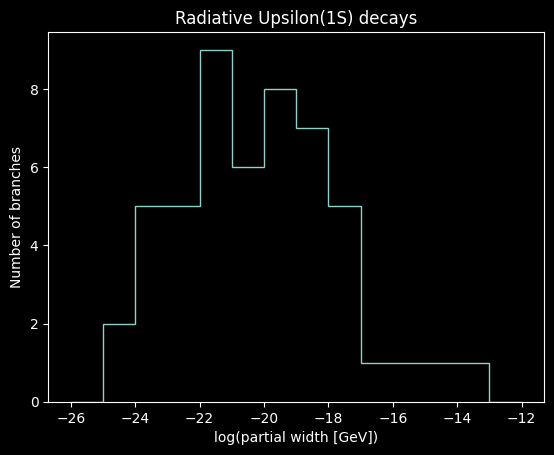

In [67]:
def produces_gamma(branch):
    return any(p.item.has_particle and p.item.particle.name == 'gamma'
               for p in branch.decay_products)

p = api.get_particle_by_name('Upsilon(1S)')
selected_branches = [branch for branch in p.branching_fractions()
                    if produces_gamma(branch)]
log_partial_widths = [np.log(p.width * b.value) for b in selected_branches]

plt.hist(log_partial_widths, histtype='step', bins=np.linspace(-26, -12, 15));
plt.xlabel("log(partial width [GeV])")
plt.ylabel('Number of branches')
plt.title('Radiative Upsilon(1S) decays');

### Plotting masses of all decay products of $D^+$

In [74]:
g = (i for i in [1, 2, 3])
g

<generator object <genexpr> at 0x7d5c20720d40>

(array([1., 1., 0., 0., 0., 1., 1., 0., 0., 2.]),
 array([5.10998950e-04, 9.00150126e-02, 1.79519026e-01, 2.69023040e-01,
        3.58527054e-01, 4.48031067e-01, 5.37535081e-01, 6.27039094e-01,
        7.16543108e-01, 8.06047122e-01, 8.95551135e-01]),
 <BarContainer object of 10 artists>)

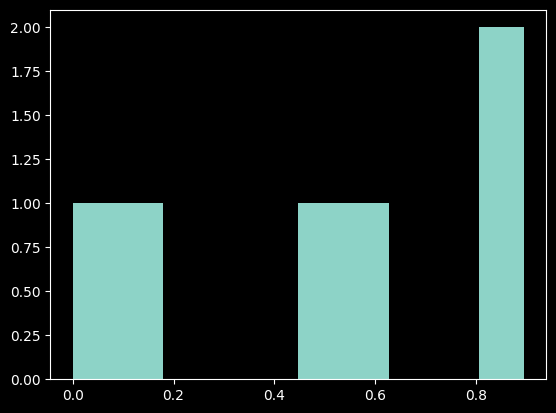

In [79]:
all_masses = set()
# p = api.get_particle_by_name('Upsilon(1S)')
p = api.get_particle_by_name('D0')
for decay in p.branching_fractions():
    for p in decay.decay_products:
        if not p.item.has_particle:
            continue
        mass_prop = next(p.item.particle.masses(), None)
        if mass_prop is None:
            continue
        all_masses.add(mass_prop.value)
plt.hist(masses)

### Plotting precision of \<some_measurement\> over time

### Getting all isospin partners of \<some_particle\>

## Direct access using SQLAlchemy

## Metadata and documentation tables